In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import unicodedata
import re
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow.keras.backend as K


c:\Users\ryuuu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', None)

# モデル学習

In [4]:
# 例：DataFrameが df で、対象の列が「レース日」
def normalize_date(s):
    # 全角→半角変換 & スペース除去
    s = unicodedata.normalize('NFKC', s).replace(" ", "")
    
    # 年・月・日 を抽出

    match = re.match(r"(\d{4})年(\d{1,2})月(\d{1,2})日", s)
    if match:
        year, month, day = match.groups()
        return f"{year}/{int(month):02}/{int(day):02}"
    return None  # フォーマット不一致時

def normalize_race_round(s):
    # 全角→半角 + スペース除去
    s = unicodedata.normalize('NFKC', s).replace(" ", "")
    
    # 数字部分を取り出す
    match = re.match(r"(\d+)R", s.upper())
    if match:
        num = int(match.group(1))
        return f"{num:02}R"
    return None

In [5]:
racelist_df = pd.read_csv(
    "./downloads/racelists/csv/timetable_200901-240901.csv", encoding="shift-jis"
)
detail_df = pd.read_csv(
    "./downloads/results/details/details_200901-240901.csv", encoding="shift-jis"
)

C:\Users\ryuuu\AppData\Local\Temp\ipykernel_24952\2303487902.py:4: DtypeWarning: Columns (6,12,13,14,16,19,22,23,26,28,29,31,32,38,39,40,41,43,46,49,50,51,53,56,59,60,61,69,75,76,77,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  detail_df = pd.read_csv(


In [6]:
detail_df["高配当"] = detail_df['3連単_人気']>=50

In [7]:
# detail_dfの展示タイムが着順に紐づいているので変更する

In [53]:
racelist_df["レース日"] = racelist_df["レース日"].apply(normalize_date)
racelist_df["レース回"] = racelist_df["レース回"].apply(normalize_race_round)
df = racelist_df.merge(detail_df, on=["レース日", "レース場", "レース回"])

df['日次'] = df['日次_x'].str.extract(r'(\d+)').astype(int)

# key_columns = ['日次', 'レース場','年齢','体重','級別','勝率','2連対率','今節成績','展示','進入コース','スタートタイミング','天候','風向き','風速','波の']
key_columns = ['日次', 'レース場','年齢','体重','級別','勝率','2連対率','今節成績','天候','風向き','風速','波の']


df_clean = df[[col for col in df.columns if any(kc in col for kc in key_columns)]]
df_clean = df_clean.drop(["日次_y","日次_x"],axis=1)

onehot_columns = ['天候','レース場','級別']
matched_columns = [col for col in df.columns if any(kc in col for kc in onehot_columns)]
df_onehot = pd.get_dummies(df_clean, columns=matched_columns)

In [54]:
df_onehot = df_onehot.map(lambda x: 0 if pd.isna(x) or (isinstance(x, str) and x.strip() == "") else x)

In [55]:
df_onehot = df_onehot.apply(pd.to_numeric,errors='coerce')
df_onehot = df_onehot.fillna(0)

In [56]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_onehot), columns=df_onehot.columns)

In [57]:
df_scaled

,1枠_年齢,1枠_体重,1枠_全国勝率,1枠_全国2連対率,1枠_当地勝率,1枠_当地2連対率,1枠_モーター2連対率,1枠_ボート2連対率,1枠_今節成績_1-1,1枠_今節成績_1-2,1枠_今節成績_2-1,1枠_今節成績_2-2,1枠_今節成績_3-1,1枠_今節成績_3-2,1枠_今節成績_4-1,1枠_今節成績_4-2,1枠_今節成績_5-1,1枠_今節成績_5-2,1枠_今節成績_6-1,1枠_今節成績_6-2,2枠_年齢,2枠_体重,2枠_全国勝率,2枠_全国2連対率,2枠_当地勝率,2枠_当地2連対率,2枠_モーター2連対率,2枠_ボート2連対率,2枠_今節成績_1-1,2枠_今節成績_1-2,2枠_今節成績_2-1,2枠_今節成績_2-2,2枠_今節成績_3-1,2枠_今節成績_3-2,2枠_今節成績_4-1,2枠_今節成績_4-2,2枠_今節成績_5-1,2枠_今節成績_5-2,2枠_今節成績_6-1,2枠_今節成績_6-2,3枠_年齢,3枠_体重,3枠_全国勝率,3枠_全国2連対率,3枠_当地勝率,3枠_当地2連対率,3枠_モーター2連対率,3枠_ボート2連対率,3枠_今節成績_1-1,3枠_今節成績_1-2,3枠_今節成績_2-1,3枠_今節成績_2-2,3枠_今節成績_3-1,3枠_今節成績_3-2,3枠_今節成績_4-1,3枠_今節成績_4-2,3枠_今節成績_5-1,3枠_今節成績_5-2,3枠_今節成績_6-1,3枠_今節成績_6-2,4枠_年齢,4枠_体重,4枠_全国勝率,4枠_全国2連対率,4枠_当地勝率,4枠_当地2連対率,4枠_モーター2連対率,4枠_ボート2連対率,4枠_今節成績_1-1,4枠_今節成績_1-2,4枠_今節成績_2-1,4枠_今節成績_2-2,4枠_今節成績_3-1,4枠_今節成績_3-2,4枠_今節成績_4-1,4枠_今節成績_4-2,4枠_今節成績_5-1,4枠_今節成績_5-2,4枠_今節成績_6-1,4枠_今節成績_6-2,5枠_年齢,5枠_体重,5枠_全国勝率,5枠_全国2連対率,5枠_当地勝率,5枠_当地2連対率,5枠_モーター2連対率,5枠_ボート2連対率,5枠_今節成績_1-1,5枠_今節成績_1-2,5枠_今節成績_2-1,5枠_今節成績_2-2,5枠_今節成績_3-1,5枠_今節成績_3-2,5枠_今節成績_4-1,5枠_今節成績_4-2,5枠_今節成績_5-1,5枠_今節成績_5-2,5枠_今節成績_6-1,5枠_今節成績_6-2,6枠_年齢,6枠_体重,6枠_全国勝率,6枠_全国2連対率,6枠_当地勝率,6枠_当地2連対率,6枠_モーター2連対率,6枠_ボート2連対率,6枠_今節成績_1-1,6枠_今節成績_1-2,6枠_今節成績_2-1,6枠_今節成績_2-2,6枠_今節成績_3-1,6枠_今節成績_3-2,6枠_今節成績_4-1,6枠_今節成績_4-2,6枠_今節成績_5-1,6枠_今節成績_5-2,6枠_今節成績_6-1,6枠_今節成績_6-2,風速(m),波の高さ(cm),日次,レース場_びわこ,レース場_住之江,レース場_多摩川,レース場_平和島,レース場_江戸川,レース場_浜名湖,レース場_琵琶湖,1枠_級別_A1,1枠_級別_A2,1枠_級別_B1,1枠_級別_B2,2枠_級別_A1,2枠_級別_A2,2枠_級別_B1,2枠_級別_B2,3枠_級別_A1,3枠_級別_A2,3枠_級別_B1,3枠_級別_B2,4枠_級別_A1,4枠_級別_A2,4枠_級別_B1,4枠_級別_B2,5枠_級別_A1,5枠_級別_A2,5枠_級別_B1,5枠_級別_B2,6枠_級別_A1,6枠_級別_A2,6枠_級別_B1,6枠_級別_B2,天候_晴,天候_曇り,天候_雨,天候_雪,天候_霧
0,-1.384180,0.513935,-2.748383,-2.265887,-2.315802,-1.960466,-0.883513,0.432320,1.200449,-0.800575,1.958887,1.897328,0.283612,2.869244,1.955970,3.671977,2.926901,-0.271743,-0.059813,-0.050671,-1.638371,-0.179614,-2.479008,-1.856276,-2.026712,-1.848566,-0.523722,-0.309004,1.704201,1.658160,0.468263,-0.644985,2.284293,2.308929,3.044080,-0.394654,2.880822,-0.259089,-0.059088,-0.048439,-0.811815,-0.178373,-0.940222,-0.880024,-1.305620,-1.440186,-0.203599,-0.032169,-0.324673,-0.748092,-0.024083,1.380896,0.765575,2.275107,2.430127,2.279594,0.478466,-0.264810,-0.058519,-0.049867,-1.567061,0.174393,-1.426691,-1.101694,-1.102555,-1.469907,0.085264,0.185112,0.647778,-0.744095,0.928830,2.378074,1.256250,-0.521076,1.234654,2.929138,2.825343,-0.266031,-0.059415,-0.047236,-1.491718,0.512605,-2.530270,-1.932148,-1.608779,-1.600659,0.294421,-1.008616,-1.321147,-0.726440,-0.996594,-0.644640,-0.743979,-0.510167,-0.525275,-0.394853,4.391646,5.228960,-0.058686,-0.046592,-1.235800,0.849673,-1.388755,-1.199540,-2.124512,-1.526444,1.214413,0.353953,-0.331879,-0.731166,1.339096,2.309720,2.126713,1.737952,2.272609,2.237151,2.842659,-0.247406,-0.058185,-0.046865,1.069850,-0.042665,1.615857,-0.426677,-0.458405,-0.449709,-0.433675,-0.434184,2.147821,-0.095576,-0.645558,-0.581458,1.158731,-0.16438,-0.566897,-0.563327,1.030150,-0.178099,-0.557431,-0.554255,1.008314,-0.182020,-0.552156,-0.543981,1.051982,-0.260018,-0.539492,-0.528082,-0.939180,3.222577,-0.551702,-0.533179,-0.867174,2.759528,0.851579,-0.684149,-0.331586,-0.048776,-0.009592
1,-1.487015,0.170233,0.059244,0.344418,-0.429441,-0.490257,0.078484,0.762075,0.689235,0.626341,1.464985,-0.660376,1.826228,2.869244,1.336818,0.952820,0.481966,-0.271743,-0.059813,-0.050671,-1.032921,0.838221,0.136256,0.042070,0.243550,0.373562,-0.573427,0.169197,1.199140,0.694588,-0.508369,0.884252,0.769218,-0.525180,1.854857,2.988772,4.486351,5.342350,-0.059088,-0.048439,-1.815491,0.497232,-1.169590,-1.354189,-2.673820,-1.818545,0.503754,-0.850783,-1.331384,-0.748092,-0.996921,-0.642299,-0.745319,-0.528478,-0.524747,-0.398438,2.901950,-0.264810,-0.058519,-0.049867,-1.373345,0.174393,-0.929381,-1.325997,0.107618,-0.369728,-0.817546,0.106258,0.152511,-0.267161,0.928830,-0.643599,0.256686,1.747412,1.820747,1.597752,0.457407,5.156550,-0.059415,-0.047236,-1.303183,-0.492763,0.841877,0.969134,0.549160,0.717781,-0.344066,0.456481,0.144391,-0.7264

In [58]:
df_single = df[['単勝_艇番','単勝_払戻金']].apply(pd.to_numeric,errors='coerce')


In [59]:
X = df_scaled.values[~df_single.isnull().values[:,0]]
y = df_single[['単勝_艇番','単勝_払戻金']][~df_single.isnull().values[:,0]]

X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
X_train,X_val,y_train,y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

## 単勝予測モデル

In [79]:
def creat_single_prediction_model():
    inputs = Input(shape=(len(df_onehot.columns),))
    model = Dense(32,activation='relu')(inputs)
    model = Dense(16,activation='relu')(model)

    outputs = Dense(6,activation='softmax')(model)
    model = Model(inputs=inputs,outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['acc']
    )
    return model


In [80]:
single_prediction_model = creat_single_prediction_model()

In [81]:
# ---- モデル学習 ----
single_prediction_model.fit(X_train, y_train.iloc[:,0]-1, epochs=10, batch_size=32, validation_data=(X_val, y_val.iloc[:,0]-1))

Epoch 1/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step - acc: 0.4749 - loss: 1.4341 - val_acc: 0.5299 - val_loss: 1.3002
Epoch 2/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - acc: 0.5259 - loss: 1.2832 - val_acc: 0.5257 - val_loss: 1.2891
Epoch 3/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - acc: 0.5330 - loss: 1.2638 - val_acc: 0.5290 - val_loss: 1.2863
Epoch 4/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - acc: 0.5381 - loss: 1.2471 - val_acc: 0.5308 - val_loss: 1.2845
Epoch 5/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - acc: 0.5336 - loss: 1.2432 - val_acc: 0.5305 - val_loss: 1.2868
Epoch 6/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - acc: 0.5426 - loss: 1.2343 - val_acc: 0.5265 - val_loss: 1.2912
Epoch 7/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - acc: 0.5473 - loss: 1.2169 - val_acc: 0.5270 - val_loss: 1.2887
Epoch 8/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - acc: 0.5359 - loss: 1.2377 - val_acc: 0.5283 - val_loss: 1.2914
Epoch 9/10
1223/1223 ━━━

In [82]:
y_pred = single_prediction_model.predict(X_test)
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

# y_test は整数ラベル 
cm = confusion_matrix(y_test.iloc[:,0]-1, y_pred)

# （任意）分類レポートも表示
print(classification_report(y_test.iloc[:,0], y_pred+1,digits=3))

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
              precision    recall  f1-score   support

         1.0      0.557     0.916     0.693      2764
         2.0      0.429     0.219     0.290       867
         3.0      0.382     0.122     0.185       727
         4.0      0.378     0.102     0.161       579
         5.0      0.269     0.022     0.040       324
         6.0      0.143     0.023     0.040       171

    accuracy                          0.531      5432
   macro avg      0.360     0.234     0.235      5432
weighted avg      0.464     0.531     0.445      5432



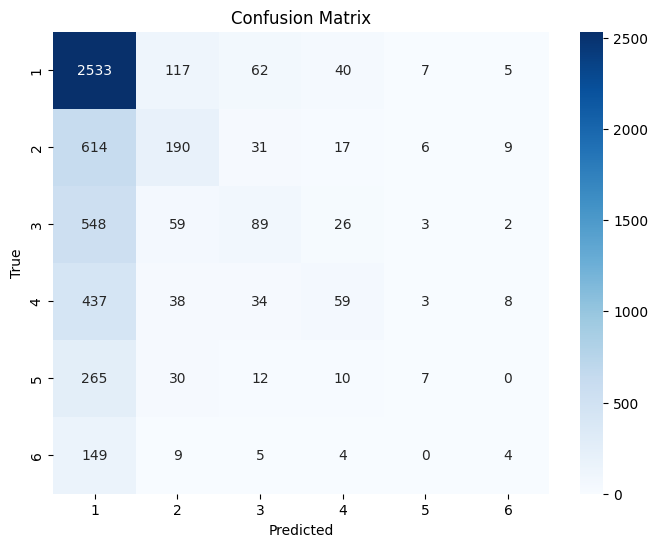

In [83]:
class_labels = np.arange(1, cm.shape[0] + 1)
plt.figure(figsize=(8,6))
sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [92]:
y_pred = single_prediction_model.predict(X_test)
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

result = []
for i in range(len(X_test)):
    gain = 0
    if y_pred[i] == y_test.iloc[i,0]-1:
        gain = y_test.iloc[i,1]
    result.append(gain)

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


In [94]:
result_sum = []
result_sum.append(result[0])
for i in range(1,len(result)):
    result_sum.append(result_sum[i-1] + result[i])

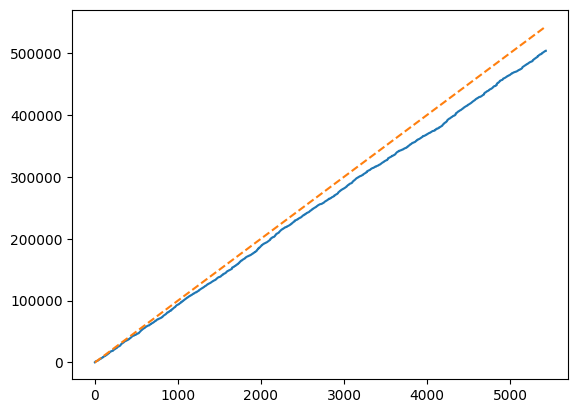

In [ ]:
plt.plot(result_sum,)
plt.plot(np.arange(0,len(result_sum),1),np.arange(0,len(result_sum),1)*100,linestyle="--")

In [124]:
print(f"回収率：{result_sum[-1]/(100*len(result_sum))*100:.2f}%")

回収率：92.76%


## 単勝予測モデル パラチューニング有り

In [133]:
# --- モデル構築関数 ---
def create_model(trial):
    units1 = trial.suggest_int('units1', 32, 128, step=32)
    units2 = trial.suggest_int('units2', 16, 64, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    inputs = Input(shape=(X.shape[1],))
    x = Dense(units1, activation=activation)(inputs)
    x = Dense(units2, activation=activation)(x)
    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model

In [134]:
# --- Optuna Objective関数 ---
def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)

    early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=5, verbose=0, restore_best_weights=True)

    history = model.fit(
        X_train, y_train.iloc[:,0]-1,
        validation_data=(X_val, y_val.iloc[:,0]-1),
        epochs=20,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    val_acc = max(history.history['val_acc'])
    return val_acc

In [135]:
# --- Optuna Study 実行 ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# --- ベスト結果 ---
print("Best trial:")
print("  Value: {:.4f}".format(study.best_trial.value))
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-06 14:52:47,175] A new study created in memory with name: no-name-70db7a1c-c663-4bca-977d-9926f3000cd0
[I 2025-05-06 14:52:50,209] Trial 0 finished with value: 0.5279198288917542 and parameters: {'units1': 128, 'units2': 16, 'activation': 'elu', 'optimizer': 'adam', 'lr': 0.0011699324137227167, 'batch_size': 96}. Best is trial 0 with value: 0.5279198288917542.
[I 2025-05-06 14:52:57,953] Trial 1 finished with value: 0.5281243324279785 and parameters: {'units1': 96, 'units2': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0015876953610230587, 'batch_size': 32}. Best is trial 1 with value: 0.5281243324279785.
[I 2025-05-06 14:53:05,233] Trial 2 finished with value: 0.5296584367752075 and parameters: {'units1': 64, 'units2': 16, 'activation': 'elu', 'optimizer': 'adam', 'lr': 0.0007294083930988226, 'batch_size': 32}. Best is trial 2 with value: 0.5296584367752075.
[I 2025-05-06 14:53:11,556] Trial 3 finished with value: 0.5022499561309814 and parameters: {'units1': 6

Best trial:
  Value: 0.5351
  Params: 
    units1: 32
    units2: 32
    activation: tanh
    optimizer: adam
    lr: 0.00025410771285645973
    batch_size: 64


In [137]:
study.best_trial.params['units1']

32

In [138]:
inputs = Input(shape=(X.shape[1],))
x = Dense(study.best_trial.params['units1'], activation=study.best_trial.params['activation'])(inputs)
x = Dense(study.best_trial.params['units2'], activation=study.best_trial.params['activation'])(x)
outputs = Dense(6, activation='softmax')(x)

best_model = Model(inputs=inputs, outputs=outputs)
best_model.compile(optimizer=study.best_trial.params['optimizer'],
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=5, verbose=0, restore_best_weights=True)

history = best_model.fit(
    X_train, y_train.iloc[:,0]-1,
    validation_data=(X_val, y_val.iloc[:,0]-1),
    epochs=20,
    batch_size=study.best_trial.params['batch_size'],
    callbacks=[early_stop],
    verbose=0
)

In [140]:
history.history['val_acc']

[0.5304765701293945,
 0.5318061113357544,
 0.5286357402801514,
 0.53037428855896,
 0.5279198288917542,
 0.5286357402801514,
 0.5275107622146606]

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
              precision    recall  f1-score   support

         1.0      0.566     0.905     0.697      2764
         2.0      0.395     0.263     0.316       867
         3.0      0.341     0.127     0.185       727
         4.0      0.310     0.045     0.078       579
         5.0      0.238     0.046     0.078       324
         6.0      0.105     0.012     0.021       171

    accuracy                          0.527      5432
   macro avg      0.326     0.233     0.229      5432
weighted avg      0.447     0.527     0.443      5432



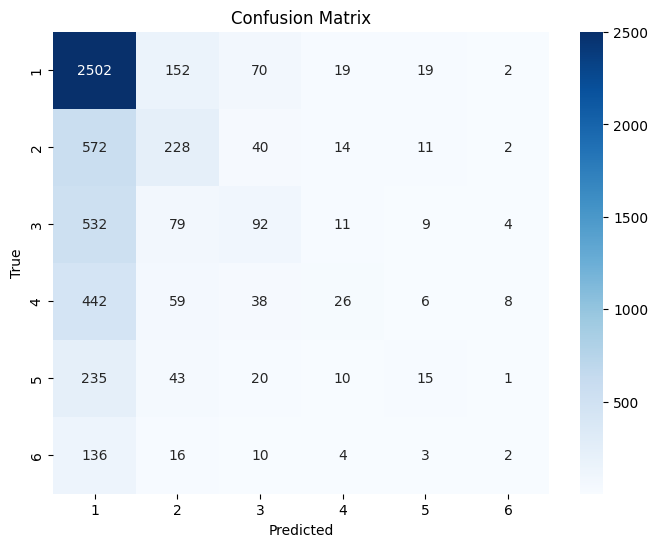

In [142]:
y_pred = best_model.predict(X_test)
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

# y_test は整数ラベル 
cm = confusion_matrix(y_test.iloc[:,0]-1, y_pred)

# （任意）分類レポートも表示
print(classification_report(y_test.iloc[:,0], y_pred+1,digits=3))

class_labels = np.arange(1, cm.shape[0] + 1)
plt.figure(figsize=(8,6))
sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
回収率：89.99%


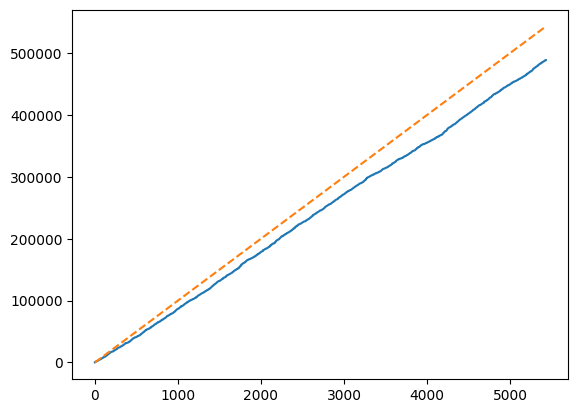

In [144]:
y_pred = best_model.predict(X_test)
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

result = []
for i in range(len(X_test)):
    gain = 0
    if y_pred[i] == y_test.iloc[i,0]-1:
        gain = y_test.iloc[i,1]
    result.append(gain)
result_sum = []
result_sum.append(result[0])
for i in range(1,len(result)):
    result_sum.append(result_sum[i-1] + result[i])
plt.plot(result_sum,)
plt.plot(np.arange(0,len(result_sum),1),np.arange(0,len(result_sum),1)*100,linestyle="--")

print(f"回収率：{result_sum[-1]/(100*len(result_sum))*100:.2f}%")

## 高配当重視モデル

In [8]:
racelist_df = pd.read_csv(
    "./downloads/racelists/csv/timetable_200901-240901.csv", encoding="shift-jis"
)
detail_df = pd.read_csv(
    "./downloads/results/details/details_200901-240901.csv", encoding="shift-jis"
)

C:\Users\ryuuu\AppData\Local\Temp\ipykernel_24952\2303487902.py:4: DtypeWarning: Columns (6,12,13,14,16,19,22,23,26,28,29,31,32,38,39,40,41,43,46,49,50,51,53,56,59,60,61,69,75,76,77,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  detail_df = pd.read_csv(


In [9]:
detail_df["高配当"] = detail_df['3連単_人気']>=30

In [10]:
racelist_df["レース日"] = racelist_df["レース日"].apply(normalize_date)
racelist_df["レース回"] = racelist_df["レース回"].apply(normalize_race_round)
df = racelist_df.merge(detail_df, on=["レース日", "レース場", "レース回"])

df['日次'] = df['日次_x'].str.extract(r'(\d+)').astype(int)

# key_columns = ['日次', 'レース場','年齢','体重','級別','勝率','2連対率','今節成績','展示','進入コース','スタートタイミング','天候','風向き','風速','波の']
key_columns = ['日次', 'レース場','年齢','体重','級別','勝率','2連対率','今節成績','天候','風向き','風速','波の','高配当']


df_clean = df[[col for col in df.columns if any(kc in col for kc in key_columns)]]
df_clean = df_clean.drop(["日次_y","日次_x"],axis=1)

onehot_columns = ['天候','レース場','級別']
matched_columns = [col for col in df.columns if any(kc in col for kc in onehot_columns)]
df_onehot = pd.get_dummies(df_clean, columns=matched_columns)

In [11]:
df_onehot = df_onehot.map(lambda x: 0 if pd.isna(x) or (isinstance(x, str) and x.strip() == "") else x)
df_onehot = df_onehot.apply(pd.to_numeric,errors='coerce')
df_onehot = df_onehot.fillna(0)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_onehot), columns=df_onehot.columns)
df_single = df[['単勝_艇番','単勝_払戻金']].apply(pd.to_numeric,errors='coerce')


In [12]:
df_scaled = df_scaled[[col for col in df_scaled.columns if col != '高配当'] + ['高配当']]

In [13]:
X = df_scaled.values[~df_single.isnull().values[:,0]]
y = df_single[['単勝_艇番','単勝_払戻金']][~df_single.isnull().values[:,0]]

X_train,X_test,y_train,y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
X_train,X_val,y_train,y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [14]:
def creat_single_prediction_model(feature_dim):
    inputs = Input(shape=(feature_dim,))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(6, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['acc']
    )
    return model

In [21]:
control = X_train[:,-1]
# control: shape = (n_samples,) or (n_samples, 1)
sample_weight = np.where(control.flatten() >= 0, 6.0, 1.0)

high_odds_model = creat_single_prediction_model(159)

history = high_odds_model.fit(
    X_train[:,:-1],
    y_train.iloc[:,0]-1,
    sample_weight=sample_weight,
    batch_size=32,
    epochs=10,
    validation_data=(X_val[:,:-1], y_val.iloc[:,0]-1)
)

Epoch 1/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step - acc: 0.4265 - loss: 3.5810 - val_acc: 0.4929 - val_loss: 1.4671
Epoch 2/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - acc: 0.5014 - loss: 3.3832 - val_acc: 0.4984 - val_loss: 1.4407
Epoch 3/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - acc: 0.5021 - loss: 3.3334 - val_acc: 0.5018 - val_loss: 1.4332
Epoch 4/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - acc: 0.5101 - loss: 3.2936 - val_acc: 0.5014 - val_loss: 1.4202
Epoch 5/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - acc: 0.5075 - loss: 3.2443 - val_acc: 0.4839 - val_loss: 1.4349
Epoch 6/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - acc: 0.4952 - loss: 3.2362 - val_acc: 0.4760 - val_loss: 1.4253
Epoch 7/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - acc: 0.4979 - loss: 3.2030 - val_acc: 0.4678 - val_loss: 1.4439
Epoch 8/10
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - acc: 0.4957 - loss: 3.1900 - val_acc: 0.4536 - val_loss: 1.4474
Epoch 9/10
1223/1223 ━━━

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
              precision    recall  f1-score   support

         1.0      0.574     0.764     0.656      2764
         2.0      0.271     0.171     0.209       867
         3.0      0.248     0.153     0.189       727
         4.0      0.189     0.135     0.157       579
         5.0      0.135     0.093     0.110       324
         6.0      0.146     0.105     0.122       171

    accuracy                          0.460      5432
   macro avg      0.260     0.237     0.241      5432
weighted avg      0.401     0.460     0.419      5432



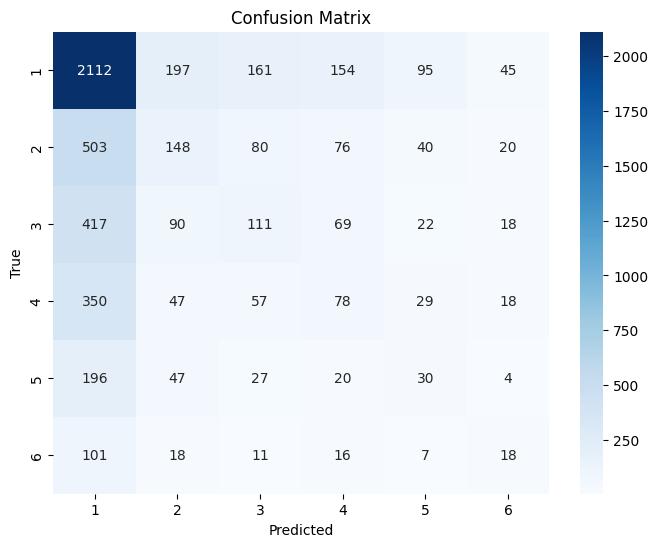

In [40]:
y_pred = high_odds_model.predict(X_test[:,:-1])
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

# y_test は整数ラベル 
cm = confusion_matrix(y_test.iloc[:,0]-1, y_pred)

# （任意）分類レポートも表示
print(classification_report(y_test.iloc[:,0], y_pred+1,digits=3))

class_labels = np.arange(1, cm.shape[0] + 1)
plt.figure(figsize=(8,6))
sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
回収率：92.40%


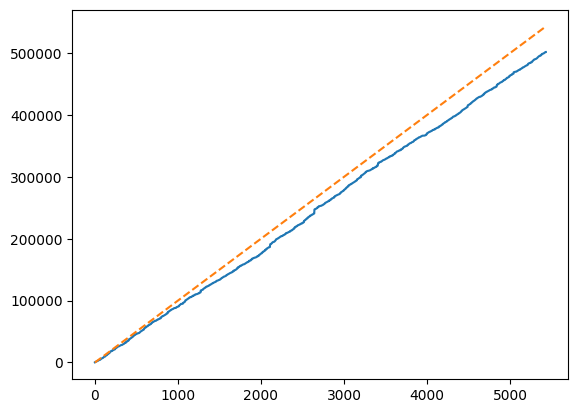

In [41]:
y_pred = high_odds_model.predict(X_test[:,:-1])
# 各サンプルで最大確率のクラスを選ぶ
y_pred = np.argmax(y_pred, axis=1)

result = []
for i in range(len(X_test)):
    gain = 0
    if y_pred[i] == y_test.iloc[i,0]-1:
        gain = y_test.iloc[i,1]
    result.append(gain)
result_sum = []
result_sum.append(result[0])
for i in range(1,len(result)):
    result_sum.append(result_sum[i-1] + result[i])
plt.plot(result_sum,)
plt.plot(np.arange(0,len(result_sum),1),np.arange(0,len(result_sum),1)*100,linestyle="--")

print(f"回収率：{result_sum[-1]/(100*len(result_sum))*100:.2f}%")

2艇分買ってみる．

In [25]:
# y_pred_proba: shape = (n_samples, n_classes)
y_pred_proba = high_odds_model.predict(X_test[:, :-1])

# Top-2クラスを取得
top2_preds = np.argsort(y_pred_proba, axis=1)[:, -2:]  # 上位2つのクラスindex（昇順なので最後の2つ）

# 実ラベル（0-indexedにする）
y_true = y_test.iloc[:, 0].to_numpy() - 1  # 元が1〜6なら 0〜5 に揃える

# Top-2に入っているか判定（True/Falseの配列）
correct_top2 = np.array([
    y_true[i] in top2_preds[i]
    for i in range(len(y_true))
])

# Top-2 Accuracy
top2_accuracy = correct_top2.mean()
print(f"Top-2 Accuracy: {top2_accuracy:.3f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
Top-2 Accuracy: 0.660


回収率：85.27%


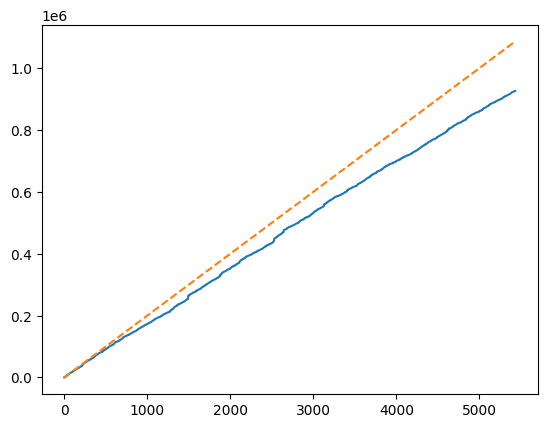

In [29]:
result = []
for i in range(len(X_test)):
    gain = 0
    if correct_top2[i]:
        gain = y_test.iloc[i,1]
    result.append(gain)
result_sum = []
result_sum.append(result[0])
for i in range(1,len(result)):
    result_sum.append(result_sum[i-1] + result[i])
plt.plot(result_sum,)
plt.plot(np.arange(0,len(result_sum),1),np.arange(0,len(result_sum),1)*200,linestyle="--")

print(f"回収率：{result_sum[-1]/(200*len(result_sum))*100:.2f}%")

In [36]:
# 1. モデル出力（確率）取得
y_pred_proba = high_odds_model.predict(X_test[:, :-1])  # shape = (n_samples, n_classes)
y_true = y_test.iloc[:, 0].to_numpy() - 1  # クラス0〜5対応

# 2. Top-2予測クラス
top2_preds = np.argsort(y_pred_proba, axis=1)[:, -2:]  # 上位2クラス（昇順）

# 3. 最大予測確率とそのクラス
max_probs = np.max(y_pred_proba, axis=1)
top1_preds = np.argmax(y_pred_proba, axis=1)

# 4. 条件に応じた正解判定
correct = []
y_pred_hybrid = []
Hybrid = []

for i in range(len(y_true)):
    if max_probs[i] >= 0.5:
        # 通常予測を採用
        y_pred_hybrid.append(top1_preds[i])
        correct.append(top1_preds[i] == y_true[i])
        Hybrid.append(False)
    else:
        # Top-2 に正解が含まれているかどうかのみ記録（予測値は便宜的に1位とする）
        y_pred_hybrid.append(top1_preds[i])  # 可視化用に1位を使用
        correct.append(y_true[i] in top2_preds[i])
        Hybrid.append(True)


# 5. 正答率
hybrid_accuracy = np.mean(correct)
print(f"Hybrid Accuracy (Top-1 if prob >= 0.5, else Top-2 match): {hybrid_accuracy:.3f}")


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
Hybrid Accuracy (Top-1 if prob >= 0.5, else Top-2 match): 0.647


回収率：81.97%


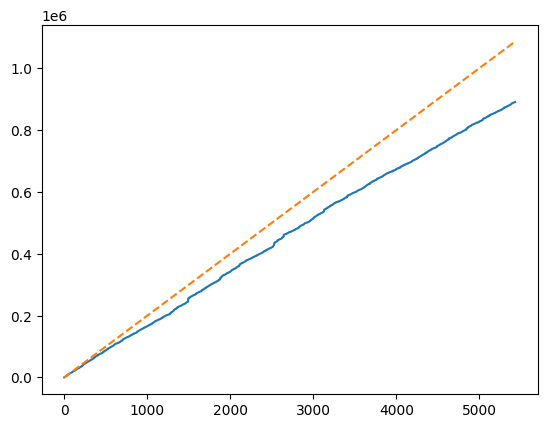

In [38]:
result = []
for i in range(len(X_test)):
    gain = 0
    if correct[i]:
        if Hybrid:
            gain = y_test.iloc[i,1]
        else:
            gain = 2*y_test.iloc[i,1]
    result.append(gain)
result_sum = []
result_sum.append(result[0])
for i in range(1,len(result)):
    result_sum.append(result_sum[i-1] + result[i])
plt.plot(result_sum,)
plt.plot(np.arange(0,len(result_sum),1),np.arange(0,len(result_sum),1)*200,linestyle="--")

print(f"回収率：{result_sum[-1]/(200*len(result_sum))*100:.2f}%")

# 予想部分

In [17]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

options = Options()
options.add_argument('--headless')  # ヘッドレスモード

# 自動でドライバ取得
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

url = 'https://www.boatrace.jp/owpc/pc/race/racelist?rno=1&jcd=04&hd=20250505'
driver.get(url)
time.sleep(3)

soup = BeautifulSoup(driver.page_source, 'html.parser')

# データ取得例（ここは状況に応じてカスタマイズ）
racer_names = soup.select('.table1 .is-fs12')
for td in racer_names:
    print(td.get_text(strip=True))

driver.quit()

１4104
                            /B1木下　　陽介東京/東京45歳/54.1kgF0L00.154.4426.3938.894.5530.0035.003540.8761.547533.6953.4874109R244.09.10.16２１４
２4895
                            /B1門間　　雄大東京/北海道33歳/53.7kgF0L00.165.2523.6152.785.8032.0058.003836.2750.002032.2149.52231211R536.12.13.15３４５
３5133
                            /B1堀越　　雄貴東京/神奈川25歳/51.5kgF0L00.184.9129.6348.154.3922.6441.515630.9848.375734.4851.15298455.13.17.13６６３
４4769
                            /A2馬場　　　剛東京/東京32歳/51.5kgF0L00.125.4530.9956.346.8252.7372.731627.7140.961133.6651.4996117R635.14.10.11５３６
５5371
                            /B2早川　　颯太東京/長野22歳/58.7kgF0L0-1.330.001.721.090.000.007236.1053.665032.3948.30415666.18.19.11６６６
６4944
                            /B1田代　　達也東京/東京33歳/52.4kgF0L00.143.8620.0034.124.1323.6828.953342.2156.783034.3650.7782810R342.13.24.07１５５


In [ ]:
# 選手ごとのtbodyを抽出
tbodies = soup.select('.table1 tbody.is-fs12')
data = []

for tbody in racer_names:
    # 枠番 o
    waku = tbody.select_one('td[class^="is-boatColor"]').get_text(strip=True)

    # 登録番号・級 o
    regclass_div = tbody.select_one('div.is-fs11')
    regclass = regclass_div.get_text(strip=True).split('/')
    reg_num = regclass[0].strip()
    grade = regclass[1].strip()

    # 選手名
    name = tbody.select_one('div.is-fs18').get_text(strip=True)

    # 支部・年齢・体重
    info = tbody.select('div.is-fs11')[1].get_text(strip=True)
    branch = info.split('/')[0]
    rest = info.split('/')[1]
    age = ''.join(filter(str.isdigit, rest.split('歳')[0]))
    weight = ''.join(filter(lambda c: c.isdigit() or c == '.', rest.split('歳')[1]))

    # F, L, ST
    flst = tbody.select('td.is-lineH2')[0].get_text(strip=True).split('\n')
    F = flst[0].replace('F', '')
    L = flst[1].replace('L', '') # flstの文字列の分割がうまく機能していない
    ST = flst[2]

    # 勝率・2連対率・3連対率
    scores = tbody.select('td.is-lineH2')[1].get_text(strip=True).split('\n')
    score = scores[0]
    win2 = scores[1]
    win3 = scores[2]

    # モーターNoなど（3つ目または4つ目の is-lineH2）
    motor_info = tbody.select('td.is-lineH2')[3].get_text(strip=True).split('\n')
    motor_no = motor_info[0]
    motor_win2 = motor_info[1]
    motor_win3 = motor_info[2]

    data.append({
        '枠番': waku,
        '登録番号': reg_num,
        '級別': grade,
        '選手名': name,
        '支部': branch,
        '年齢': age,
        '体重': weight,
        'F': F,
        'L': L,
        'ST': ST,
        '勝率': score,
        '2連対率': win2,
        '3連対率': win3,
        'モーターNo': motor_no,
        'モーター2連対率': motor_win2,
        'モーター3連対率': motor_win3
    })


# DataFrameに変換
df = pd.DataFrame(data)
print(df)

IndexError: list index out of range

In [27]:
text = """１4104
                            /B1木下　　陽介東京/東京45歳/54.1kgF0L00.154.4426.3938.894.5530.0035.003540.8761.547533.6953.4874109R244.09.10.16２１４
２4895
                            /B1門間　　雄大東京/北海道33歳/53.7kgF0L00.165.2523.6152.785.8032.0058.003836.2750.002032.2149.52231211R536.12.13.15３４５
３5133
                            /B1堀越　　雄貴東京/神奈川25歳/51.5kgF0L00.184.9129.6348.154.3922.6441.515630.9848.375734.4851.15298455.13.17.13６６３
４4769
                            /A2馬場　　　剛東京/東京32歳/51.5kgF0L00.125.4530.9956.346.8252.7372.731627.7140.961133.6651.4996117R635.14.10.11５３６
５5371
                            /B2早川　　颯太東京/長野22歳/58.7kgF0L0-1.330.001.721.090.000.007236.1053.665032.3948.30415666.18.19.11６６６
６4944
                            /B1田代　　達也東京/東京33歳/52.4kgF0L00.143.8620.0034.124.1323.6828.953342.2156.783034.3650.7782810R342.13.24.07１５５"""

In [28]:
# 正規表現で選手データを抽出（1〜6人分）
racer_blocks = re.findall(r'[１-６]\d{4}[\s\S]*?(?=[１-６]\d{4}|$)', text)

# 変換用リスト
data = []

for block in racer_blocks:
    try:
        block = block.replace('\n', '').replace(' ', '')  # 改行・スペース除去

        # 枠番・登録番号
        waku = block[0]
        regno = block[1:5]

        # 級別
        kyuu = re.search(r'/([AB]\d)', block).group(1)

        # 選手名（漢字2〜3＋全角スペース＋2〜3文字）
        name_match = re.search(r'[AB]\d(.{4,8})[都道府県]', block)
        name = name_match.group(1) if name_match else '不明'

        # 支部
        branch_match = re.search(r'([都道府県]{2})/([都道府県]{2})', block)
        branch = branch_match.group(2) if branch_match else '不明'

        # 年齢・体重
        age = re.search(r'(\d{2})歳', block).group(1)
        weight = re.search(r'(\d{2,3}\.\d)kg', block).group(1)

        # F, L, ST
        flst_match = re.search(r'F(\d)L(\d)([-]?\d\.\d{2})', block)
        F = flst_match.group(1)
        L = flst_match.group(2)
        ST = flst_match.group(3)

        # 勝率（最初の3つ）
        winrates = re.findall(r'(\d\.\d{2})', block)
        win1, win2, win3 = winrates[:3] if len(winrates) >= 3 else ('', '', '')

        data.append({
            '枠番': waku,
            '登録番号': regno,
            '級別': kyuu,
            '選手名': name,
            '支部': branch,
            '年齢': age,
            '体重': weight,
            'F': F,
            'L': L,
            'ST': ST,
            '勝率': win1,
            '2連対率': win2,
            '3連対率': win3
        })

    except Exception as e:
        print(f'エラー: {e}')
        continue

# DataFrameへ変換
df = pd.DataFrame(data)
print(df)

  枠番  登録番号  級別 選手名  支部  年齢    体重  F  L     ST    勝率  2連対率  3連対率
0  １  4104  B1  不明  不明  45  54.1  0  0   0.15  0.15  4.44  6.39
1  ２  4895  B1  不明  不明  33  53.7  0  0   0.16  0.16  5.25  3.61
2  ３  5133  B1  不明  不明  25  51.5  0  0   0.18  0.18  4.91  9.63
3  ４  4769  A2  不明  不明  32  51.5  0  0   0.12  0.12  5.45  0.99
4  ５  5371  B2  不明  不明  22  58.7  0  0  -1.33  1.33  0.00  1.72
5  ６  4944  B1  不明  不明  33  52.4  0  0   0.14  0.14  3.86  0.00
